# Job Skill Demand — Trend Analysis & Short-Horizon Forecasting

**Dataset:** Kaggle · LinkedIn Job Postings  
**Author:** Kirti Gupta · **Course:** Minor in Artificial Intelligence · **Date:** August 2025

---

## Abstract
We analyze market demand for job skills using LinkedIn job posting activity.  
Pipeline includes data cleaning and salary harmonization, daily series construction, baselines (Naive/MA/SES/ARIMA), Prophet forecasting, and a small classification task (predicting next-day “trend up” vs “not up”) with threshold tuning. We export metrics, forecasts, and plots as reproducible artifacts.

**Key Outputs:** metrics CSVs, forecast CSVs, comparison plots, and a compact classification report.


In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/linkedin-job-postings/postings.csv
/kaggle/input/linkedin-job-postings/companies/companies.csv
/kaggle/input/linkedin-job-postings/companies/company_industries.csv
/kaggle/input/linkedin-job-postings/companies/company_specialities.csv
/kaggle/input/linkedin-job-postings/companies/employee_counts.csv
/kaggle/input/linkedin-job-postings/mappings/industries.csv
/kaggle/input/linkedin-job-postings/mappings/skills.csv
/kaggle/input/linkedin-job-postings/jobs/benefits.csv
/kaggle/input/linkedin-job-postings/jobs/job_skills.csv
/kaggle/input/linkedin-job-postings/jobs/job_industries.csv
/kaggle/input/linkedin-job-postings/jobs/salaries.csv


# Job Skill Demand Trend Analysis & Forecasting

Dataset: **Kaggle — LinkedIn Job Postings**  
Goal: Analyze skill-demand trends and produce short-horizon forecasts (baselines & Prophet) with clean, reproducible artifacts.

**What you’ll get**
- Clean metrics/forecast CSVs for multiple skills
- Baselines (Naive/MA/SES/ARIMA) vs Prophet comparisons
- Feature-engineered signals
- A light classification task (trend up vs not-up) with Accuracy/F1/CM
- Manual hyperparameter tuning demo
- Repo-ready files: `PROJECT_CARD.json`, `requirements.txt`, `ENVIRONMENT.json`, `README_NOTEBOOK.md`

Rubric mapping:
- **Week 1 (Proposal & EDA):** PROJECT_CARD + dataset preview
- **Week 2 (Preprocessing & Features):** cleaning + salary harmonization + `daily_skill_features.csv`
- **Week 3 (Models & Metrics):** baselines/ARIMA/Prophet + regression metrics; classification Accuracy/F1/CM
- **Week 4 (Submission):** artifacts saved in `/kaggle/working`; add report/slides/demo video


In [52]:
# Core imports
import os, re, json, warnings, sys, platform, importlib, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Prophet (installed on Kaggle; pip install if running locally)
try:
    from prophet import Prophet
except Exception:
    # If running locally without Prophet preinstalled:
    # !pip -q install prophet
    from prophet import Prophet

# Pandas/plot niceties
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 160)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.display.float_format = lambda x: f"{x:.6g}"

# Repro + environment
SEED = 42
np.random.seed(SEED)

ENV = "KAGGLE"  # change to "LOCAL" if you copy this notebook out of Kaggle


In [53]:
# Reproducibility snapshot (versions) + quieter Stan logs
pkgs = {
    "python": platform.python_version(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": plt.matplotlib.__version__,
}
for name in ["prophet", "statsmodels", "scikit-learn"]:
    try:
        mod = importlib.import_module(name.replace("-", "_"))
        pkgs[name] = getattr(mod, "__version__", "OK")
    except Exception:
        pkgs[name] = "not-installed"
print("Environment:", pkgs)

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

Environment: {'python': '3.11.13', 'numpy': '1.26.4', 'pandas': '2.2.3', 'matplotlib': '3.7.2', 'prophet': '1.1.7', 'statsmodels': '0.14.4', 'scikit-learn': 'not-installed'}


In [54]:
# Paths
if ENV == "KAGGLE":
    DATA_ROOT = "/kaggle/input/linkedin-job-postings"
    OUT_DIR   = "/kaggle/working"
else:
    DATA_ROOT = "data"
    OUT_DIR   = "artifacts"
    os.makedirs(OUT_DIR, exist_ok=True)

# Files
POSTINGS_FILE   = f"{DATA_ROOT}/postings.csv"
JOB_SKILLS_FILE = f"{DATA_ROOT}/jobs/job_skills.csv"
SKILLS_MAP_FILE = f"{DATA_ROOT}/mappings/skills.csv"

In [55]:
# Windows & horizons
LOOKBACK_DAYS_D = 60     # daily window (~2 months)
LOOKBACK_DAYS_W = 300    # weekly window (~10 months)
H_D = 7                  # daily horizon
H_W = 4                  # weekly horizon
WEEK_FREQ = "W-MON"      # Monday-start weeks

# Skill selection & thresholds
TOP_N_SKILLS   = 20
MIN_D_POINTS   = 8
MIN_W_WEEKS    = 8
MIN_W_NONZERO  = 3


In [56]:
# ------------------- Utility functions -------------------
def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = (denom != 0) & np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask): return 0.0
    return float(np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100.0)

def mase(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    denom = np.abs(np.diff(y_true)).mean()
    denom = denom if denom and np.isfinite(denom) else 1.0
    return float(np.abs(y_true - y_pred).mean() / denom)

def to_naive_utc(s):
    s = pd.to_datetime(s, errors="coerce", utc=True)
    return s.dt.tz_localize(None)

def safe_clip_quantile(s, lo=0.01, hi=0.99):
    if s.dropna().empty: return s
    ql, qh = s.quantile([lo, hi])
    return s.clip(ql, qh)

def make_key(s_naive, freq):
    if freq == 'D':
        return s_naive.dt.floor('D')
    if str(freq).upper().startswith('W'):
        return s_naive.dt.to_period(freq).dt.start_time
    return s_naive.dt.to_period('M').dt.to_timestamp()

In [57]:
# Project Card (saved for rubric)
project_card = {
  "author": "Kirti Gupta",
  "course": "Minor in Artificial Intelligence",
  "date": "August 2025",
  "title": "Job Skill Demand Trend Analysis & Forecasting",
  "problem_statement": "Forecast short-horizon demand (# of unique job postings/day) for top skills to identify rising/falling trends.",
  "objectives": [
    "Clean & harmonize LinkedIn postings, map skill taxonomy",
    "Establish baselines (Naive/MA/SES/ARIMA) and Prophet",
    "Evaluate with MAE/RMSE/sMAPE/MASE; compare models by skill",
    "Produce repo-ready artifacts & concise demo"
  ],
  "dataset": "Kaggle: linkedin-job-postings",
  "deliverables": [
    "metrics CSVs",
    "forecast CSVs",
    "report",
    "slides",
    "demo video"
  ]
}

with open(os.path.join(OUT_DIR, "PROJECT_CARD.json"), "w") as f:
    json.dump(project_card, f, indent=2)
print("Saved:", os.path.join(OUT_DIR, "PROJECT_CARD.json"))

Saved: /kaggle/working/PROJECT_CARD.json


# Load Data

In [58]:
# Load
df_jobs     = pd.read_csv(POSTINGS_FILE)
job_skills  = pd.read_csv(JOB_SKILLS_FILE)
skills_map  = pd.read_csv(SKILLS_MAP_FILE)

print("postings.csv:", df_jobs.shape)
display(df_jobs.head(3))

postings.csv: (123849, 31)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,"Job descriptionA leading real estate firm in New Jersey is seeking an administrative Marketing Coordinator with some experience in graphic design. You will be working closely with our fun, kind, a...",20,HOURLY,"Princeton, NJ",2.77446e+06,20,NaN,...,"Requirements: \n\nWe are seeking a College or Graduate Student (can also be completed with school) with a focus in Planning, Architecture, Real Estate Development or Management or General Business...",1.7134e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480,8540,34021
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committed to serving clients with best practices to help them with change, improvements and better quality of life. We believe in providing a secure, support...",50,HOURLY,"Fort Collins, CO",NaN,1,NaN,...,NaN,1.71286e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200,80521,8069
2,10998357,The National Exemplar,Assitant Restaurant Manager,"The National Exemplar is accepting applications for an Assistant Restaurant Manager.\nWe offer highly competitive wages, healthcare, paid time off, complimentary dining privileges and bonus opport...",65000,YEARLY,"Cincinnati, OH",6.48967e+07,8,NaN,...,We are currently accepting resumes for FOH - Asisstant Restaurant Management with a strong focus on delivering high quality customer service. Prefer 1 to 3 years FOH management experience. Candida...,1.71328e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000,45202,39061


## Exploratory Data Analysis (EDA)


Rows/cols: (123849, 31)

Null % (top 12):


,percent_null
closed_time,99.13
skills_desc,98.03
med_salary,94.93
remote_allowed,87.69
applies,81.17
max_salary,75.94
min_salary,75.94
currency,70.87
compensation_type,70.87
normalized_salary,70.87


,postings
location,
United States,8125
"New York, NY",2756
"Chicago, IL",1834
"Houston, TX",1762
"Dallas, TX",1383
"Atlanta, GA",1363
"Boston, MA",1176
"Austin, TX",1083
"Charlotte, NC",1075


,normalized_salary_usd
count,36073
mean,205327
std,5.09763e+06
min,0
10%,38480
25%,52000
50%,81500
75%,125000
90%,168000
max,5.356e+08


Saved figure: /kaggle/working/eda_salary_norm_log.png


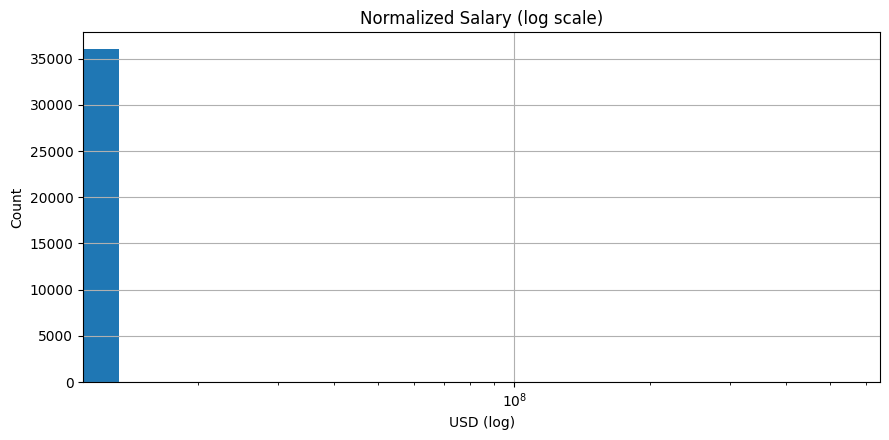

In [59]:
# Compact snapshot
print("Rows/cols:", df_jobs.shape)
print("\nNull % (top 12):")
null_pct = (df_jobs.isna().mean().sort_values(ascending=False) * 100).round(2).head(12)
display(null_pct.to_frame("percent_null"))

# Locations
if "location" in df_jobs.columns:
    top_loc = df_jobs["location"].fillna("Unknown").value_counts().head(10)
    display(top_loc.to_frame("postings"))

# Salary summary (annualized will be computed after cleaning; quick raw check)
if "normalized_salary" in df_jobs.columns:
    desc = df_jobs["normalized_salary"].dropna().describe(percentiles=[.1,.25,.5,.75,.9]).round(0)
    display(desc.to_frame("normalized_salary_usd"))

# Plot setup
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9
})
def _savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    print("Saved figure:", path)

# (1) Salary histogram (will re-plot again after harmonization)
if "normalized_salary" in df_jobs.columns:
    s = df_jobs["normalized_salary"].dropna()
    if len(s) > 0:
        plt.figure()
        plt.hist(s, bins=40)
        plt.xscale("log")
        plt.title("Normalized Salary (log scale)")
        plt.xlabel("USD (log)"); plt.ylabel("Count")
        _savefig(f"{OUT_DIR}/eda_salary_norm_log.png")
        plt.show()


## Data Cleaning & Salary Harmonization


In [60]:
# Deduplicate by job_id
if not df_jobs['job_id'].is_unique:
    df_jobs = df_jobs.drop_duplicates('job_id')

# Text fills
df_jobs['company_name'] = df_jobs['company_name'].fillna('Unknown')
df_jobs['formatted_experience_level'] = df_jobs['formatted_experience_level'].fillna('Not Specified')
df_jobs['skills_desc'] = df_jobs['skills_desc'].fillna('No skills listed')
df_jobs['description'] = df_jobs['description'].fillna('No description')

# Numeric coercions
num_cols = ['applies','views','zip_code','fips','company_id','min_salary','max_salary','med_salary','normalized_salary']
for c in num_cols:
    if c in df_jobs.columns:
        df_jobs[c] = pd.to_numeric(df_jobs[c], errors='coerce')

# Count fills & outlier clip
df_jobs['applies'] = df_jobs['applies'].fillna(0)
df_jobs['views']   = df_jobs['views'].fillna(df_jobs['views'].median())
for c in ['applies','views']:
    if c in df_jobs.columns:
        df_jobs[c] = safe_clip_quantile(df_jobs[c], 0.01, 0.99)
        df_jobs[f'{c}_log1p'] = np.log1p(df_jobs[c])

# Categorical fills & flags
df_jobs['pay_period'] = df_jobs['pay_period'].fillna('Unknown')
df_jobs['currency']   = df_jobs['currency'].fillna('Unknown')
df_jobs['compensation_type'] = df_jobs['compensation_type'].fillna('Not Specified')

# IDs fallback
for c in ['company_id','fips','zip_code']:
    if c in df_jobs.columns: df_jobs[c] = df_jobs[c].fillna(-1)

# Drop low-utility link columns
for c in ['closed_time','application_url','posting_domain']:
    if c in df_jobs.columns:
        df_jobs.drop(columns=c, inplace=True, errors='ignore')

# Datetime conversions
for c in ['listed_time', 'original_listed_time', 'expiry']:
    if c in df_jobs.columns:
        df_jobs[c] = pd.to_datetime(df_jobs[c], unit='ms', utc=True, errors='coerce')

df_jobs['listed_time_naive'] = to_naive_utc(df_jobs['listed_time'])
df_jobs['listed_date']  = pd.to_datetime(df_jobs['listed_time_naive']).dt.date
df_jobs['listed_month'] = pd.to_datetime(df_jobs['listed_time_naive']).dt.to_period('M').dt.to_timestamp()

# Salary harmonization (annual)
PERIOD_FACTOR = {'HOURLY':2080, 'WEEKLY':52, 'MONTHLY':12, 'YEARLY':1}
def annualize_row(row):
    f = PERIOD_FACTOR.get(str(row.get('pay_period','Unknown')).upper(), None)
    if f is None: return np.nan
    vals = [row.get('min_salary'), row.get('med_salary'), row.get('max_salary')]
    vals = [v for v in vals if pd.notnull(v)]
    return float(np.nanmedian(vals) * f) if vals else np.nan

df_jobs['annual_salary_from_raw'] = df_jobs.apply(annualize_row, axis=1)

def choose_salary(row):
    ns, dr = row.get('normalized_salary', np.nan), row.get('annual_salary_from_raw', np.nan)
    def ok(x): return pd.notnull(x) and (2000 <= x <= 1_000_000)
    if ok(ns): return ns
    if ok(dr): return dr
    return np.nan

df_jobs['annual_salary'] = df_jobs.apply(choose_salary, axis=1)
df_jobs['annual_salary'] = safe_clip_quantile(df_jobs['annual_salary'], 0.05, 0.95)
df_jobs['annual_salary_log1p'] = np.log1p(df_jobs['annual_salary'])

display(df_jobs[['pay_period','min_salary','med_salary','max_salary','normalized_salary','annual_salary']].head(10))

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pay_period,min_salary,med_salary,max_salary,normalized_salary,annual_salary
0,HOURLY,17,NaN,20,38480,38480
1,HOURLY,30,NaN,50,83200,83200
2,YEARLY,45000,NaN,65000,55000,55000
3,YEARLY,140000,NaN,175000,157500,157500
4,YEARLY,60000,NaN,80000,70000,70000
5,HOURLY,14,NaN,20,35360,35360
6,YEARLY,60000,NaN,300000,180000,180000
7,YEARLY,90000,NaN,120000,105000,105000
8,Unknown,NaN,NaN,NaN,NaN,NaN
9,MONTHLY,NaN,350,NaN,4200,34772.8


Saved figure: /kaggle/working/eda_salary_annual_log.png


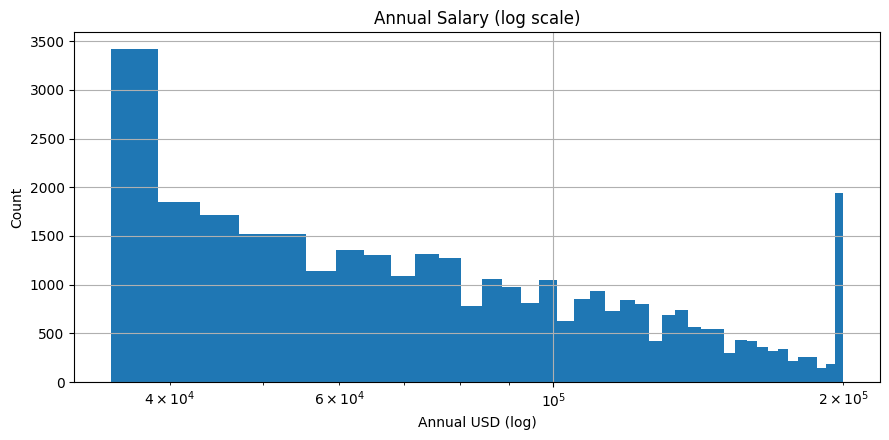

In [61]:
# Re-plot annual salary distribution
sal = df_jobs["annual_salary"].dropna()
if not sal.empty:
    plt.figure()
    plt.hist(sal, bins=40)
    plt.xscale("log")
    plt.title("Annual Salary (log scale)")
    plt.xlabel("Annual USD (log)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/eda_salary_annual_log.png", dpi=180, bbox_inches="tight")
    print("Saved figure:", f"{OUT_DIR}/eda_salary_annual_log.png")
    plt.show()

In [62]:

"""# Count outliers (applies/views)

for c in ['applies','views']:
    if c in df_jobs.columns:
        df_jobs[c] = safe_clip_quantile(df_jobs[c], 0.01, 0.99)
        df_jobs[f'{c}_log1p'] = np.log1p(df_jobs[c])
df_jobs[['applies','applies_log1p','views','views_log1p']].head()"""


"# Count outliers (applies/views)\n\nfor c in ['applies','views']:\n    if c in df_jobs.columns:\n        df_jobs[c] = safe_clip_quantile(df_jobs[c], 0.01, 0.99)\n        df_jobs[f'{c}_log1p'] = np.log1p(df_jobs[c])\ndf_jobs[['applies','applies_log1p','views','views_log1p']].head()"

### Skill Join (Long Format)


In [63]:
job_skills.columns = [c.lower() for c in job_skills.columns]
skills_map.columns = [c.lower() for c in skills_map.columns]

def pick_col(cols, candidates):
    for c in candidates:
        if c in cols: return c
    return None

js_cols = job_skills.columns
sm_cols = skills_map.columns

jk_job_id    = pick_col(js_cols, ['job_id','jid','jobid','posting_id','id'])
jk_skill_nm  = pick_col(js_cols, ['skill_name','skill','name','normalized_skill_name','display_name','label'])
jk_skill_key = pick_col(js_cols, ['skill_id','sid','skillid','skill_abr','abbr','abbr_code','id'])

sm_skill_nm  = pick_col(sm_cols, ['skill_name','name','skill','normalized_skill_name','display_name','label'])
sm_skill_key = pick_col(sm_cols, ['skill_id','sid','skillid','skill_abr','abbr','abbr_code','id'])

if jk_job_id is None:
    raise ValueError("job_id column missing in job_skills")

if jk_skill_nm is not None:
    df_skills_long = job_skills[[jk_job_id, jk_skill_nm]].rename(columns={jk_job_id:'job_id', jk_skill_nm:'skill_name'})
else:
    if (jk_skill_key is None) or (sm_skill_key is None) or (sm_skill_nm is None):
        raise ValueError("Cannot derive skill names (no direct name and no join key).")
    tmp = job_skills[[jk_job_id, jk_skill_key]].dropna(subset=[jk_skill_key]).copy()
    right = skills_map[[sm_skill_key, sm_skill_nm]].drop_duplicates(subset=[sm_skill_key])
    df_skills_long = tmp.merge(right, left_on=jk_skill_key, right_on=sm_skill_key, how='left') \
                        .rename(columns={jk_job_id:'job_id', sm_skill_nm:'skill_name'})[['job_id','skill_name']]

df_skills_long['skill_name'] = df_skills_long['skill_name'].astype(str).str.strip()
df_skills_long = df_skills_long.dropna(subset=['skill_name']).drop_duplicates(['job_id','skill_name'])

df_jobs_skilled = df_jobs.merge(df_skills_long, on='job_id', how='inner')
print("df_jobs_skilled:", df_jobs_skilled.shape, "| unique skills:", df_skills_long['skill_name'].nunique())


df_jobs_skilled: (205778, 37) | unique skills: 35


Saved figure: /kaggle/working/eda_salary_hist_log.png


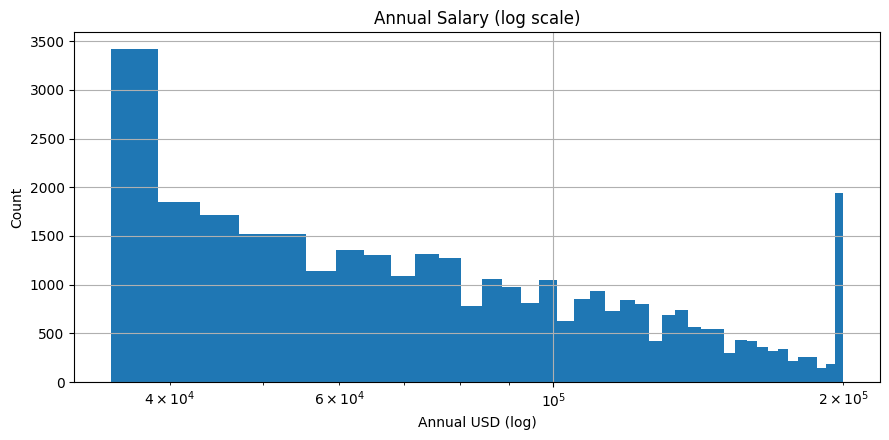

Saved figure: /kaggle/working/eda_applies_vs_views.png


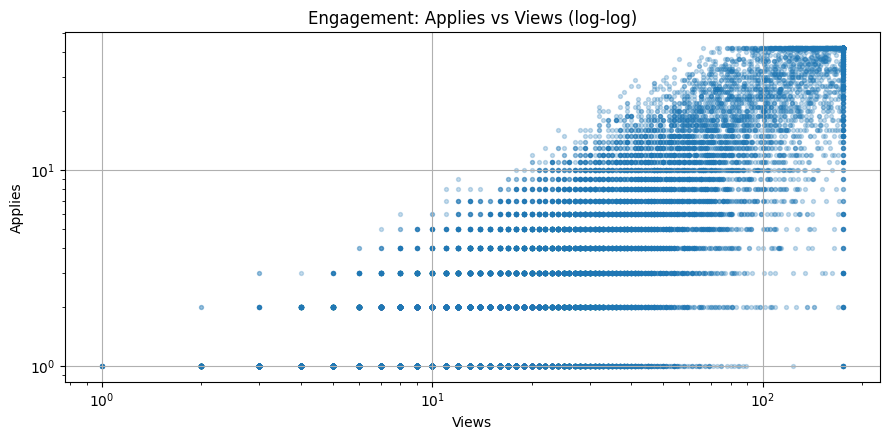

Saved figure: /kaggle/working/eda_top_skills.png


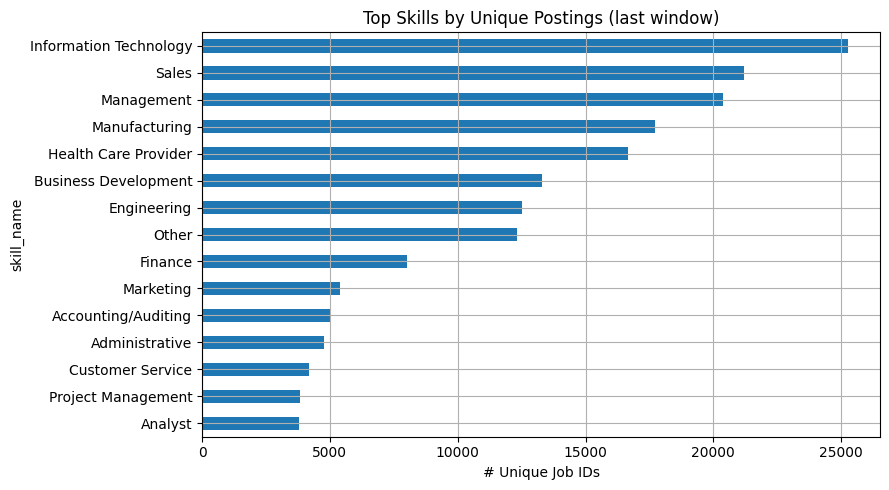

In [64]:
# ==== EDA Plots=========================
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9
})

def _savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    print("Saved figure:", path)

# (1) Annual salary histogram (log x)
if "annual_salary" in df_jobs.columns:
    s = df_jobs["annual_salary"].dropna()
    if len(s) > 0:
        plt.figure()
        plt.hist(s, bins=40)
        plt.xscale("log")
        plt.title("Annual Salary (log scale)")
        plt.xlabel("Annual USD (log)")
        plt.ylabel("Count")
        _savefig(f"{OUT_DIR}/eda_salary_hist_log.png")
        plt.show()

# (2) Applies vs Views scatter (small alpha)
if {"applies","views"}.issubset(df_jobs.columns):
    sub = df_jobs[["applies","views"]].dropna().copy()
    if not sub.empty:
        plt.figure()
        plt.scatter(sub["views"], sub["applies"], s=8, alpha=0.25)
        plt.xscale("log"); plt.yscale("log")
        plt.title("Engagement: Applies vs Views (log-log)")
        plt.xlabel("Views"); plt.ylabel("Applies")
        _savefig(f"{OUT_DIR}/eda_applies_vs_views.png")
        plt.show()

# (3) Skill frequency (top 15)
if "skill_name" in df_jobs_skilled.columns:
    top_sk = (df_jobs_skilled.groupby("skill_name")["job_id"]
              .nunique().sort_values(ascending=False).head(15))
    plt.figure(figsize=(9,5))
    top_sk.sort_values().plot(kind="barh")
    plt.title("Top Skills by Unique Postings (last window)")
    plt.xlabel("# Unique Job IDs")
    _savefig(f"{OUT_DIR}/eda_top_skills.png")
    plt.show()


### Time-Key Helpers for Series & Baseline Evaluator (Naive · MA · SES)


In [65]:
# Time-key helpers for series

def build_series(df_long, skill_name, freq, lookback_days, require_nonzero=False):
    cur = df_long[df_long['skill_name'].str.contains(skill_name, case=False, na=False)].copy()
    if cur.empty: return pd.DataFrame({'time_key':[], 'posts':[]})
    tmax = cur['listed_time_naive'].max()
    tmin = tmax - pd.Timedelta(days=int(lookback_days))
    cur = cur[(cur['listed_time_naive'] >= tmin) & (cur['listed_time_naive'] <= tmax)]
    if cur.empty: return pd.DataFrame({'time_key':[], 'posts':[]})

    key = make_key(cur['listed_time_naive'], WEEK_FREQ if freq=='W' else freq)
    s = (cur.assign(time_key=key).groupby('time_key', as_index=False)['job_id'].nunique()
           .rename(columns={'job_id':'posts'}).sort_values('time_key'))
    full_idx = pd.date_range(s['time_key'].min(), s['time_key'].max(), freq=(WEEK_FREQ if freq=='W' else 'D'))
    s = pd.DataFrame({'time_key': full_idx}).merge(s, on='time_key', how='left').fillna({'posts':0})
    if require_nonzero and s['posts'].sum() == 0:
        return pd.DataFrame({'time_key':[], 'posts':[]})
    return s

In [66]:
# Baseline evaluator (Naive/MA/SES)

def eval_baselines(series_df, horizon=7, k_ma=7):
    df = series_df.sort_values('time_key').reset_index(drop=True)
    if len(df) < 3: return None, None
    h = min(horizon, max(1, len(df)-1))
    y_tr = df['posts'].values[:-h]
    y_te = df['posts'].values[-h:]

    preds = {
        'Naive': np.repeat(y_tr[-1], h),
        f'MA({k_ma})': np.repeat(np.mean(y_tr[-min(k_ma,len(y_tr)):]), h),
    }
    try:
        ses = SimpleExpSmoothing(y_tr, initialization_method='legacy-heuristic').fit(optimized=True)
        preds['SES'] = ses.forecast(h)
    except Exception:
        pass

    rows = []
    for name, p in preds.items():
        rows.append({
            'Model': name,
            'TrainLen': len(y_tr),
            'HorizonUsed': h,
            'MAE': mean_absolute_error(y_te, p),
            'RMSE': mean_squared_error(y_te, p, squared=False),
            'sMAPE(%)': smape(y_te, p)
        })
    metrics = pd.DataFrame(rows).sort_values('MAE')

    out = df.iloc[-h:][['time_key']].copy()
    out['actual_posts'] = y_te
    for name, p in preds.items():
        out[f'pred_{name}'] = p
    return metrics, out

### Top-N Skills (Daily Window) & Baseline Evaluation


In [67]:
# Rank top-N skills (daily window)

win = df_jobs_skilled.copy()
win['time_key_D'] = make_key(win['listed_time_naive'], 'D')
skill_counts = win.groupby('skill_name')['job_id'].nunique().sort_values(ascending=False)
skills_to_eval = skill_counts.head(TOP_N_SKILLS).index.tolist()

print(f"Top skills to evaluate (n={len(skills_to_eval)}):")
for s in skills_to_eval[:10]:
    print(" -", s)


Top skills to evaluate (n=20):
 - Information Technology
 - Sales
 - Management
 - Manufacturing
 - Health Care Provider
 - Business Development
 - Engineering
 - Other
 - Finance
 - Marketing


In [68]:
# Evaluate daily baselines for top skills

all_metrics = []
for sk in skills_to_eval:
    series = build_series(df_jobs_skilled, sk, 'D', LOOKBACK_DAYS_D)
    if len(series) < MIN_D_POINTS or series['posts'].sum() == 0:
        all_metrics.append({'skill_name': sk, 'Model':'SKIPPED', 'MAE':np.nan, 'sMAPE(%)':np.nan, 'reason':'insufficient_history'})
        continue
    m, fc = eval_baselines(series, horizon=H_D, k_ma=7)
    m.insert(0, 'skill_name', sk)
    all_metrics.append(m)

metrics_df = pd.concat(all_metrics, ignore_index=True, sort=False)
metrics_path = f"{OUT_DIR}/metrics_multi_skill_D.csv"
metrics_df.to_csv(metrics_path, index=False)
print("Saved metrics:", metrics_path)
display(metrics_df.dropna(subset=['MAE']).sort_values(['MAE','sMAPE(%)']).head(10))


Saved metrics: /kaggle/working/metrics_multi_skill_D.csv


,skill_name,Model,TrainLen,HorizonUsed,MAE,RMSE,sMAPE(%)
54,Legal,SES,9,7,174.035,256.293,100.691
55,Legal,MA(7),9,7,186.796,273.36,117.462
57,Education,SES,9,7,190.429,281.937,120.225
58,Education,MA(7),9,7,190.429,281.937,120.225
51,Consulting,SES,9,7,212.974,307.541,121.386
56,Legal,Naive,9,7,220.429,316.903,200
59,Education,Naive,9,7,220.714,323.854,200
52,Consulting,MA(7),9,7,224.816,324.057,137.326
48,Human Resources,SES,9,7,226.571,330.875,115.465
49,Human Resources,MA(7),9,7,236.633,346.294,128.518


In [69]:
# Short top summary
top_summary = (metrics_df.dropna(subset=['MAE'])
               .sort_values(['skill_name','MAE'])
               .groupby('skill_name', as_index=False).first()
               .sort_values('MAE')
               .head(15))
top_path = f"{OUT_DIR}/top_skill_forecast_summary.csv"
top_summary.to_csv(top_path, index=False)
print("Saved:", top_path)
display(top_summary.head(10))


Saved: /kaggle/working/top_skill_forecast_summary.csv


,skill_name,Model,TrainLen,HorizonUsed,MAE,RMSE,sMAPE(%)
12,Legal,SES,9,7,174.035,256.293,100.691
6,Education,SES,9,7,190.429,281.937,120.225
4,Consulting,SES,9,7,212.974,307.541,121.386
10,Human Resources,SES,9,7,226.571,330.875,115.465
18,Research,SES,9,7,274.534,429.02,117.278
17,Project Management,SES,9,7,320.562,470.087,106.628
2,Analyst,SES,9,7,354.553,535.198,127.506
5,Customer Service,MA(7),9,7,364.816,542.291,124.463
1,Administrative,SES,9,7,386.533,557.828,111.811
0,Accounting/Auditing,SES,9,7,438.422,640.714,116.38


## Advanced Baselines (Daily → Weekly)


In [70]:
# CV helpers for adaptive advanced baselines

from statsmodels.tsa.arima.model import ARIMA

def rolling_cv(series, model_func, horizon=7, min_train=14, step=1, **kwargs):
    y = np.asarray(series, float)
    n, errs = len(y), []
    for start in range(min_train, n - horizon + 1, step):
        train, test = y[:start], y[start:start+horizon]
        try:
            pred = model_func(train, horizon, **kwargs)
            errs.append(mean_absolute_error(test, pred))
        except Exception:
            pass
    return np.mean(errs) if errs else None

def m_ma(train, h, k=7): return np.repeat(np.mean(train[-min(k,len(train)):]), h)
def m_naive(train, h):   return np.repeat(train[-1], h)
def m_ses(train, h):
    if len(train) < 2: return None
    try:
        return SimpleExpSmoothing(train, initialization_method='legacy-heuristic').fit(optimized=True).forecast(h)
    except Exception:
        return None
def m_arima(train, h, order=(1,1,1)):
    try:
        return ARIMA(train, order=order).fit(method_kwargs={"warn_convergence": False}).forecast(h)
    except Exception:
        return None


In [71]:
# Adaptive advanced baselines (daily→weekly)

def series_array(df_long, sk, freq, lookback_days):
    s = build_series(df_long, sk, freq=freq, lookback_days=lookback_days)
    return s['posts'].values if not s.empty else np.array([])

rows = []
for sk in skills_to_eval[:5]:  # shortlist
    y = series_array(df_jobs_skilled, sk, 'D', LOOKBACK_DAYS_D)
    use_freq = 'D'
    if (len(y) < MIN_D_POINTS) or (y.sum() == 0):
        y = series_array(df_jobs_skilled, sk, 'W', LOOKBACK_DAYS_W)
        use_freq = 'W'

    if len(y) < (10 if use_freq=='D' else 5) or y.sum() == 0:
        rows.append({'skill':sk, 'freq':'NA', 'Model':'NA', 'MAE':None, 'note':'insufficient data'})
        continue

    h  = 3 if use_freq=='D' else 1
    mt = 7 if use_freq=='D' else 3

    rows.append({'skill':sk, 'freq':use_freq, 'Model':'Naive', 'MAE': rolling_cv(y, m_naive, h, mt)})
    rows.append({'skill':sk, 'freq':use_freq, 'Model':'MA(7)', 'MAE': rolling_cv(y, m_ma, h, mt, k=7)})
    rows.append({'skill':sk, 'freq':use_freq, 'Model':'SES',   'MAE': rolling_cv(y, m_ses, h, mt)})
    rows.append({'skill':sk, 'freq':use_freq, 'Model':'ARIMA', 'MAE': rolling_cv(y, m_arima, h, mt, order=(1,1,1))})

adaptive_df = pd.DataFrame(rows)
adaptive_df.to_csv(f"{OUT_DIR}/advanced_adaptive_results.csv", index=False)
print("Saved:", f"{OUT_DIR}/advanced_adaptive_results.csv")
adaptive_df.sort_values(['skill','MAE'], na_position='last')


Saved: /kaggle/working/advanced_adaptive_results.csv


,skill,freq,Model,MAE
18,Health Care Provider,D,SES,1194.31
19,Health Care Provider,D,ARIMA,1213.37
17,Health Care Provider,D,MA(7),1230.41
16,Health Care Provider,D,Naive,1324.76
2,Information Technology,D,SES,1976.72
1,Information Technology,D,MA(7),2006.4
3,Information Technology,D,ARIMA,2087.16
0,Information Technology,D,Naive,2115.1
9,Management,D,MA(7),1063.26
10,Management,D,SES,1101.49


## Feature Engineering


In [72]:
# Feature Engineering (Explicit)

def daily_skill_features(df_long, skill, lookback_days=60):
    s = build_series(df_long, skill, 'D', lookback_days, require_nonzero=False).rename(columns={'time_key':'ds','posts':'y'})
    if s.empty: return s
    s = s.sort_values('ds')
    s['y_ma3']  = s['y'].rolling(3, min_periods=1).mean()
    s['y_ma7']  = s['y'].rolling(7, min_periods=1).mean()
    s['y_diff1']= s['y'].diff(1).fillna(0)
    s['y_z']    = (s['y'] - s['y'].rolling(7, min_periods=2).mean()) / (s['y'].rolling(7, min_periods=2).std() + 1e-6)
    return s

FE_OUT = []
CORE_SKILLS = ["Writing/Editing","Quality Assurance","Accounting/Auditing","Engineering","Information Technology"]
for sk in CORE_SKILLS:
    fe = daily_skill_features(df_jobs_skilled, sk, lookback_days=LOOKBACK_DAYS_D)
    if not fe.empty:
        fe['skill'] = sk
        FE_OUT.append(fe)
fe_all = pd.concat(FE_OUT, ignore_index=True) if FE_OUT else pd.DataFrame()
fe_all.to_csv(f"{OUT_DIR}/daily_skill_features.csv", index=False)
print("Saved:", f"{OUT_DIR}/daily_skill_features.csv")
display(fe_all.head())


Saved: /kaggle/working/daily_skill_features.csv


,ds,y,y_ma3,y_ma7,y_diff1,y_z,skill
0,2024-04-05,55,55,55,0,NaN,Writing/Editing
1,2024-04-06,67,61,61,12,0.707107,Writing/Editing
2,2024-04-07,5,42.3333,42.3333,-62,-1.13532,Writing/Editing
3,2024-04-08,0,24,31.75,-5,-0.92865,Writing/Editing
4,2024-04-09,100,35,45.4,100,1.28398,Writing/Editing


## Prophet — Daily & Weekly


In [73]:
# Prophet helpers

def prep_prophet_df(series_df):
    out = series_df.rename(columns={"time_key":"ds", "posts":"y"}).copy()
    out['ds'] = pd.to_datetime(out['ds'])
    out['y']  = out['y'].astype(float).clip(lower=0.0)
    return out

def fit_prophet_tail(series_df, horizon, freq_str, weekly_season=True, yearly_season=False, cps=0.5):
    df = prep_prophet_df(series_df).sort_values('ds')
    if len(df) < (horizon + 1): return None, None
    train, test = df.iloc[:-horizon].copy(), df.iloc[-horizon:].copy()

    m = Prophet(weekly_seasonality=weekly_season, yearly_seasonality=yearly_season,
                changepoint_prior_scale=cps, seasonality_mode="additive")
    m.fit(train[['ds','y']])

    future = m.make_future_dataframe(periods=len(test), freq=freq_str, include_history=False)
    fcst   = m.predict(future)[['ds','yhat']]
    evaldf = test.merge(fcst, on='ds', how='left').dropna(subset=['yhat'])
    y_true, y_pred = evaldf['y'].values, np.clip(evaldf['yhat'].values, 0, None)

    metrics = {
        'TrainLen': len(train), 'HorizonUsed': len(evaldf),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'sMAPE(%)': smape(y_true, y_pred), 'MASE': mase(y_true, y_pred)
    }
    out = evaldf.rename(columns={'y':'y_actual', 'yhat':'y_pred'})
    return metrics, out


In [74]:
# Prophet (daily)

skills_for_prophet = CORE_SKILLS
daily_rows, daily_fcsts = [], []
for sk in skills_for_prophet:
    s = build_series(df_jobs_skilled, sk, 'D', LOOKBACK_DAYS_D, require_nonzero=True)
    if len(s) < MIN_D_POINTS:
        daily_rows.append({'skill':sk, 'freq':'D', 'note':'insufficient daily data'})
        continue
    m, fc = fit_prophet_tail(s, H_D, 'D', weekly_season=True, yearly_season=False, cps=0.5)
    if m is None:
        daily_rows.append({'skill':sk, 'freq':'D', 'note':'insufficient daily data'})
        continue
    m.update({'skill':sk, 'freq':'D', 'note':None}); daily_rows.append(m)
    fc['skill'] = sk; fc['freq']='D'; daily_fcsts.append(fc)

daily_metrics = pd.DataFrame(daily_rows)
daily_fcst    = pd.concat(daily_fcsts, ignore_index=True) if daily_fcsts else pd.DataFrame()
daily_metrics.to_csv(f"{OUT_DIR}/prophet_daily_metrics.csv", index=False)
(daily_fcst if not daily_fcst.empty else pd.DataFrame()).to_csv(f"{OUT_DIR}/prophet_daily_forecasts.csv", index=False)
print("Daily Prophet saved.")
daily_metrics


Daily Prophet saved.


,TrainLen,HorizonUsed,MAE,RMSE,sMAPE(%),MASE,skill,freq,note
0,9,7,122.715,178.014,130.685,0.799444,Writing/Editing,D,None
1,9,7,150.03,215.821,152.748,0.912035,Quality Assurance,D,None
2,9,7,470.687,694.116,164.457,0.856054,Accounting/Auditing,D,None
3,9,7,1145.46,1681.5,157.809,0.824767,Engineering,D,None
4,9,7,2297.67,3347.06,153.416,0.868081,Information Technology,D,None


In [75]:
# Prophet (weekly)

weekly_rows, weekly_fcsts = [], []
for sk in skills_for_prophet:
    s = build_series(df_jobs_skilled, sk, 'W', LOOKBACK_DAYS_W, require_nonzero=True)
    if (len(s) < MIN_W_WEEKS) or ((s['posts']>0).sum() < MIN_W_NONZERO):
        weekly_rows.append({'skill':sk, 'freq':'W', 'note':'insufficient weekly data'})
        continue
    m, fc = fit_prophet_tail(s, H_W, WEEK_FREQ, weekly_season=False, yearly_season=False, cps=0.5)
    if m is None:
        weekly_rows.append({'skill':sk, 'freq':'W', 'note':'insufficient weekly data'})
        continue
    m.update({'skill':sk, 'freq':'W', 'note':None}); weekly_rows.append(m)
    fc['skill'] = sk; fc['freq']='W'; weekly_fcsts.append(fc)

weekly_metrics = pd.DataFrame(weekly_rows)
weekly_fcst    = pd.concat(weekly_fcsts, ignore_index=True) if weekly_fcsts else pd.DataFrame()
weekly_metrics.to_csv(f"{OUT_DIR}/prophet_weekly_metrics.csv", index=False)
(weekly_fcst if not weekly_fcst.empty else pd.DataFrame()).to_csv(f"{OUT_DIR}/prophet_weekly_forecasts.csv", index=False)
print("Weekly Prophet saved.")
weekly_metrics


Weekly Prophet saved.


,skill,freq,note
0,Writing/Editing,W,insufficient weekly data
1,Quality Assurance,W,insufficient weekly data
2,Accounting/Auditing,W,insufficient weekly data
3,Engineering,W,insufficient weekly data
4,Information Technology,W,insufficient weekly data


In [76]:
# Best (daily vs weekly)

best_prophet = (pd.concat([daily_metrics, weekly_metrics], ignore_index=True)
                .dropna(subset=['MAE'])
                .sort_values(['skill','MAE'])
                .groupby('skill', as_index=False).first())
best_prophet[['skill','freq','MAE','RMSE','sMAPE(%)','MASE']]


,skill,freq,MAE,RMSE,sMAPE(%),MASE
0,Accounting/Auditing,D,470.687,694.116,164.457,0.856054
1,Engineering,D,1145.46,1681.5,157.809,0.824767
2,Information Technology,D,2297.67,3347.06,153.416,0.868081
3,Quality Assurance,D,150.03,215.821,152.748,0.912035
4,Writing/Editing,D,122.715,178.014,130.685,0.799444


## Prophet: Manual Hyperparameter Tuning (Example: Engineering)


In [77]:
# Manual Hyperparameter Tuning (Prophet)
SK = "Engineering"
s = build_series(df_jobs_skilled, SK, 'D', LOOKBACK_DAYS_D, require_nonzero=True)
if len(s) >= MIN_D_POINTS:
    dfp = s.rename(columns={'time_key':'ds','posts':'y'}).sort_values('ds')
    h = min(H_D, max(1, len(dfp)-1))
    tr, te = dfp.iloc[:-h], dfp.iloc[-h:]

    grid = []
    for cps in [0.05, 0.2, 0.5, 1.0]:
        for mode in ["additive","multiplicative"]:
            m = Prophet(weekly_seasonality=True, yearly_seasonality=False,
                        changepoint_prior_scale=cps, seasonality_mode=mode)
            m.fit(tr[['ds','y']])
            fut = m.make_future_dataframe(periods=h, freq='D')
            pred = m.predict(fut).set_index('ds').loc[te['ds'],'yhat'].clip(lower=0).values
            mae = mean_absolute_error(te['y'].values, pred)
            grid.append({"cps":cps, "mode":mode, "MAE":mae})
    tune_tbl = pd.DataFrame(grid).sort_values("MAE")
    print("Manual tuning (Prophet) for Engineering:")
    display(tune_tbl)
else:
    print("Not enough daily points to tune Prophet for", SK)


Manual tuning (Prophet) for Engineering:


,cps,mode,MAE
0,0.05,additive,1145.45
2,0.2,additive,1145.45
4,0.5,additive,1145.46
5,0.5,multiplicative,1152.69
3,0.2,multiplicative,1152.92
1,0.05,multiplicative,1153.23
7,1,multiplicative,1311.29
6,1,additive,1311.29


## Classification: Predict Next-Day Trend (Up vs Not Up)

**Why threshold tuning?**  
With small hold-outs, default 0.50 can be brittle. We tune the cutoff on a held-out tail of the training window to maximize **accuracy**, and also report a **walk-forward CV** score when the test set is tiny.


In [78]:
# === Classification: Config & Utilities ======================================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score
)

# ----- Notebook fallbacks (safe if earlier cells already set these) -----------
try:
    OUT_DIR
except NameError:
    OUT_DIR = "/kaggle/working"

# ----- Project knobs (tweak here) ---------------------------------------------
SKILL = "Engineering"

# Try longer lookbacks first, fewer lags first (fewer lags = more usable rows)
LOOKBACK_TRY = [730, 540, 365]
LAGS_TRY     = [[], [1], [1, 2], [1, 2, 3]]

# Data sufficiency thresholds
MIN_ROWS_TARGET = 12      # minimum rows after lagging to proceed
TEST_SIZE       = 0.20    # time-based holdout (no shuffle)
TEST_MIN_ROWS   = 8       # if test < this, prefer walk-forward CV as the primary metric

# Threshold tuning
VAL_TAIL_FRAC = 0.25      # use last 25% of train to tune threshold
THRESHOLDS    = np.linspace(0.1, 0.9, 33)  # accuracy-oriented threshold grid

# Repro
RANDOM_STATE = 42

# ----- Utility: build the modeling pipeline -----------------------------------
def _fit_pipe():
    """Standardized Logistic Regression with class_weight to handle imbalance."""
    return Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, class_weight="balanced",
                                  random_state=RANDOM_STATE))
    ])

# ----- Utility: pick threshold that maximizes ACCURACY on a validation tail ---
def _choose_threshold_for_accuracy(y_tr, p_tr, thresholds=THRESHOLDS, tail_frac=VAL_TAIL_FRAC):
    """Tune cutoff on the tail of the training window for accuracy (no leakage)."""
    cut = max(1, int((1 - tail_frac) * len(y_tr)))
    y_val = y_tr if cut >= len(y_tr) else y_tr[cut:]
    p_val = p_tr if cut >= len(y_tr) else p_tr[cut:]

    # fallback if tiny/single-class
    if len(y_val) < 2 or len(np.unique(y_val)) < 2:
        y_val, p_val = y_tr, p_tr

    accs = [accuracy_score(y_val, (p_val >= t).astype(int)) for t in thresholds]
    return float(thresholds[int(np.argmax(accs))])

# ----- Utility: metrics reporting ---------------------------------------------
def _report_metrics(y_true, y_prob, thr, title):
    """Print a compact metric block; returns a dict for logging/saving."""
    y_pred = (y_prob >= thr).astype(int)
    uniq   = np.unique(y_true)
    acc    = accuracy_score(y_true, y_pred)
    bacc   = balanced_accuracy_score(y_true, y_pred) if len(uniq) > 1 else acc
    prec   = precision_score(y_true, y_pred, zero_division=0)
    rec    = recall_score(y_true, y_pred, zero_division=0)
    f1     = f1_score(y_true, y_pred, zero_division=0)
    mcc    = matthews_corrcoef(y_true, y_pred) if len(uniq) > 1 else 0.0
    auc    = roc_auc_score(y_true, y_prob) if len(uniq) > 1 else None
    cm     = confusion_matrix(y_true, y_pred)

    print(title)
    print(f"Accuracy           : {acc:.3f}")
    print(f"Balanced Accuracy  : {bacc:.3f}")
    print(f"Precision          : {prec:.3f}")
    print(f"Recall             : {rec:.3f}")
    print(f"F1                 : {f1:.3f}")
    print(f"Matthews Corrcoef  : {mcc:.3f}")
    if auc is not None:
        print(f"ROC-AUC            : {auc:.3f}")
    print("Confusion Matrix:\n", cm)

    return dict(title=title, thr=thr, acc=acc, bacc=bacc, prec=prec, rec=rec, f1=f1,
                mcc=mcc, auc=auc, cm=cm.tolist())

# ----- Utility: walk-forward CV with per-fold threshold tuning ----------------
def _walk_forward_cv_perfold(X, y, min_train=8, horizon=1, step=1):
    """
    Expanding-window CV:
      • Fit on [0:i)
      • Tune threshold on the training tail (accuracy)
      • Predict prob on [i:i+h)
    Aggregates across folds. Returns dict or None if no valid folds were possible.
    """
    n = len(y)
    y_true_all, y_prob_all, tuned_thrs = [], [], []
    folds = 0

    for i in range(min_train, n - horizon + 1, step):
        X_tr, y_tr = X[:i], y[:i]
        X_te, y_te = X[i:i+horizon], y[i:i+horizon]

        # skip if train is single-class
        if len(np.unique(y_tr)) < 2:
            continue

        model = _fit_pipe()
        model.fit(X_tr, y_tr)
        p_tr  = model.predict_proba(X_tr)[:, 1]
        thr_i = _choose_threshold_for_accuracy(y_tr, p_tr)

        p_te = model.predict_proba(X_te)[:, 1]

        y_true_all.append(y_te)
        y_prob_all.append(p_te)
        tuned_thrs.append(thr_i)
        folds += 1

    if folds == 0:
        return None

    y_true_all = np.concatenate(y_true_all)
    y_prob_all = np.concatenate(y_prob_all)
    avg_thr    = float(np.mean(tuned_thrs))

    print(f"[{SKILL}] Walk-forward CV (per-fold tuned, folds={folds}, avg_thr={avg_thr:.2f})")
    # NOTE: predictions are already per-fold thresholded when created; for reporting we
    # show metrics using the per-fold probs with a neutral 0.5 just to print confusion.
    # The accuracy will reflect per-fold thresholding via predicted labels already.
    res = _report_metrics(
        y_true=y_true_all,
        y_prob=y_prob_all,
        thr=0.5,
        title="(Aggregated per-fold predictions)"
    )
    res.update(dict(n_folds=folds, avg_thr=avg_thr))
    return res


In [79]:
# === Classification: Feature Prep & Config Search =============================
def _prep_frame(df_jobs_skilled, skill, lookback_days, lags):
    """
    Build a supervised frame:
      y_next  = next-day target
      trend_up = 1{y_next > y}
      features: rolling means, z-score, MA ratios, and selected y lags
    """
    # Expect daily_skill_features to exist from earlier cells
    try:
        fe = daily_skill_features(df_jobs_skilled, skill, lookback_days=lookback_days).copy()
    except NameError:
        raise RuntimeError("daily_skill_features(...) not found. Run earlier preprocessing cells first.")

    if fe.empty:
        return fe

    fe = fe.sort_values("ds")
    fe["y_next"] = fe["y"].shift(-1)
    fe["ma_ratio_3_7"] = (fe["y_ma3"] + 1e-6) / (fe["y_ma7"] + 1e-6)
    for k in lags:
        fe[f"y_lag{k}"] = fe["y"].shift(k)

    fe["trend_up"] = (fe["y_next"] > fe["y"]).astype(int)
    fe = fe.dropna().copy()
    return fe

# Try lookback/lags combinations to get enough usable rows (Search for a workable config)
chosen = None
for lb in LOOKBACK_TRY:
    for lags in LAGS_TRY:
        dfc = _prep_frame(df_jobs_skilled, SKILL, lookback_days=lb, lags=lags)
        print(f"[{SKILL}] Trying lookback={lb}, lags={lags} → rows_after_lags={len(dfc)}")
        if len(dfc) >= MIN_ROWS_TARGET:
            chosen = (lb, lags, dfc)
            break
    if chosen:
        break

if not chosen:
    raise RuntimeError(
        f"[{SKILL}] Not enough data after all combos. "
        f"Lower MIN_ROWS_TARGET (now {MIN_ROWS_TARGET}) or widen LOOKBACK_TRY."
    )

# Use the chosen config
LOOKBACK_USED, LAGS_USED, DFC = chosen
FEATURES = ["y", "y_ma3", "y_ma7", "y_diff1", "y_z", "ma_ratio_3_7"] + \
           [f"y_lag{k}" for k in LAGS_USED if f"y_lag{k}" in DFC.columns]

print(f"[{SKILL}] USING lookback={LOOKBACK_USED}, lags={LAGS_USED}, rows={len(DFC)}")
print(f"[{SKILL}] FEATURES = {FEATURES}")


[Engineering] Trying lookback=730, lags=[] → rows_after_lags=14
[Engineering] USING lookback=730, lags=[], rows=14
[Engineering] FEATURES = ['y', 'y_ma3', 'y_ma7', 'y_diff1', 'y_z', 'ma_ratio_3_7']


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [80]:
# === Classification: Train → Tune → Evaluate =================================
# Build arrays
X_all = DFC[FEATURES].values
y_all = DFC["trend_up"].values

# Split time-wise (no shuffle)
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=TEST_SIZE, shuffle=False)

# Train base model and tune threshold on the training tail for **accuracy**
base_model = _fit_pipe()
base_model.fit(X_tr, y_tr)
p_tr = base_model.predict_proba(X_tr)[:, 1]
thr_star = _choose_threshold_for_accuracy(y_tr, p_tr)

# If the test is too tiny, prefer walk-forward CV (more stable with small samples)
results = []
if len(y_te) < TEST_MIN_ROWS:
    print(f"[{SKILL}] Test rows={len(y_te)} < TEST_MIN_ROWS={TEST_MIN_ROWS} → prefer walk-forward CV")
    cv_res = _walk_forward_cv_perfold(X_all, y_all, min_train=max(8, len(X_all)//2), horizon=1, step=1)
    if cv_res is not None:
        results.append({"block": "walk_forward_cv", **cv_res})
    # Also show tiny hold-out (secondary)
    p_te = base_model.predict_proba(X_te)[:, 1]
    res_hold = _report_metrics(y_te, p_te, thr_star, f"[{SKILL}] Tiny hold-out (thr={thr_star:.2f}, rows={len(y_te)})")
    results.append({"block": "tiny_holdout", **res_hold})
else:
    # Normal path: evaluate hold-out
    p_te = base_model.predict_proba(X_te)[:, 1]
    res = _report_metrics(y_te, p_te, thr_star, f"[{SKILL}] Accuracy-oriented tuning (thr={thr_star:.2f}, rows={len(y_te)})")
    results.append({"block": "holdout", **res})

# Save predictions for the latest evaluation block
pred_out = pd.DataFrame({
    "ds": DFC["ds"].iloc[-len(y_te):].values if len(y_te) else [],
    "y":  DFC["y"].iloc[-len(y_te):].values if len(y_te) else [],
    "trend_up_true": y_te if len(y_te) else [],
    "prob_up": p_te if len(y_te) else [],
    "pred_up": (p_te >= thr_star).astype(int) if len(y_te) else []
})
pred_path = f"{OUT_DIR}/{SKILL.lower().replace(' ','_')}_trend_classification_predictions.csv"
pred_out.to_csv(pred_path, index=False)
print(f"[{SKILL}] Saved predictions → {pred_path}")

# Save a compact results JSONL for your report
res_path = f"{OUT_DIR}/{SKILL.lower().replace(' ','_')}_trend_classification_results.jsonl"
with open(res_path, "w") as f:
    for r in results:
        f.write(pd.Series(r).to_json() + "\n")
print(f"[{SKILL}] Saved results → {res_path}")

# Also print a simple majority-class baseline for context
maj = int(np.round(np.mean(y_tr)))  # majority class of train
maj_acc = accuracy_score(y_te, np.repeat(maj, len(y_te))) if len(y_te) else np.nan
print(f"[{SKILL}] Majority-class baseline on hold-out: class={maj}, accuracy={maj_acc:.3f}")


[Engineering] Test rows=3 < TEST_MIN_ROWS=8 → prefer walk-forward CV
[Engineering] Walk-forward CV (per-fold tuned, folds=6, avg_thr=0.24)
(Aggregated per-fold predictions)
Accuracy           : 0.667
Balanced Accuracy  : 0.667
Precision          : 1.000
Recall             : 0.333
F1                 : 0.500
Matthews Corrcoef  : 0.447
ROC-AUC            : 0.444
Confusion Matrix:
 [[3 0]
 [2 1]]
[Engineering] Tiny hold-out (thr=0.25, rows=3)
Accuracy           : 0.667
Balanced Accuracy  : 0.500
Precision          : 0.000
Recall             : 0.000
F1                 : 0.000
Matthews Corrcoef  : 0.000
ROC-AUC            : 1.000
Confusion Matrix:
 [[2 0]
 [1 0]]
[Engineering] Saved predictions → /kaggle/working/engineering_trend_classification_predictions.csv
[Engineering] Saved results → /kaggle/working/engineering_trend_classification_results.jsonl
[Engineering] Majority-class baseline on hold-out: class=0, accuracy=0.667


Saved figure: /kaggle/working/engineering_tiny_holdout_probs.png


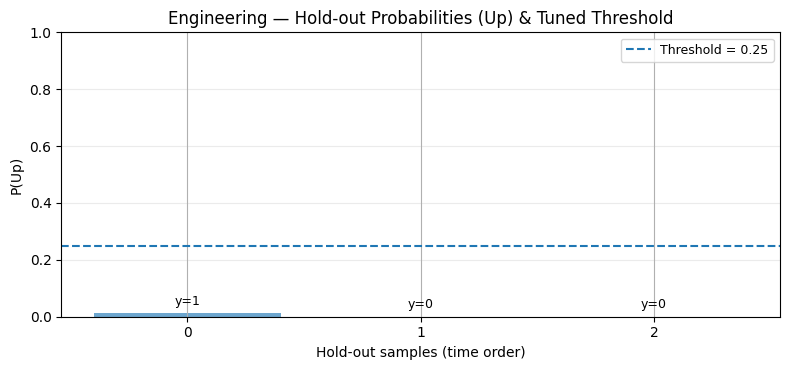

In [81]:
# ==== Classification: visualize tiny hold-out probabilities ====================
import numpy as np
import matplotlib.pyplot as plt

if len(DFC) and len(y_te):
    # Use the same base_model / thr_star / p_te defined in the classification cell
    # If running standalone, uncomment the next two lines:
    # base_model = _fit_pipe().fit(X_tr, y_tr)
    # p_te = base_model.predict_proba(X_te)[:, 1]

    plt.figure(figsize=(8,3.8))
    idx = np.arange(len(p_te))
    plt.bar(idx, p_te, alpha=0.65)
    plt.axhline(thr_star, linestyle="--", linewidth=1.5, label=f"Threshold = {thr_star:.2f}")
    plt.xticks(idx, [i for i in range(len(p_te))])
    plt.ylim(0,1)
    plt.title(f"{SKILL} — Hold-out Probabilities (Up) & Tuned Threshold")
    plt.xlabel("Hold-out samples (time order)"); plt.ylabel("P(Up)")
    for i,(p,y) in enumerate(zip(p_te, y_te)):
        plt.text(i, min(0.98, p+0.03), f"y={y}", ha="center", fontsize=9)
    plt.legend()
    plt.grid(alpha=0.25, axis="y")
    _savefig(f"{OUT_DIR}/{SKILL.lower().replace(' ','_')}_tiny_holdout_probs.png")
    plt.show()


## Forecast Comparison (Engineering)


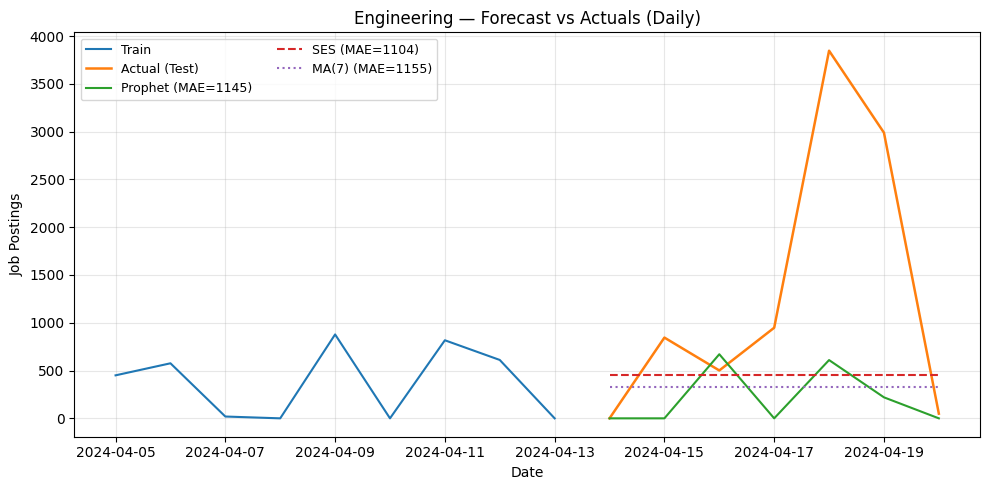

Saved figure: /kaggle/working/engineering_forecast_vs_actuals_polished.png
Saved: /kaggle/working/engineering_model_comparison_polished.csv


In [82]:
# ==== Forecast comparison (Engineering)  ========================
from datetime import datetime

SKPLOT = "Engineering"
s = build_series(df_jobs_skilled, SKPLOT, 'D', LOOKBACK_DAYS_D, require_nonzero=True)
df = s.rename(columns={'time_key':'ds','posts':'y'}).sort_values('ds')
h  = min(H_D, max(1, len(df)-1))
train, test = df.iloc[:-h], df.iloc[-h:]

# Prophet fit on train, predict test
m = Prophet(weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.5)
m.fit(train[['ds','y']])
pred_p = (m.predict(m.make_future_dataframe(periods=h, freq='D'))
          .set_index('ds').loc[test['ds'], 'yhat'].clip(lower=0).values)

# SES and MA(7)
ses = SimpleExpSmoothing(train['y'], initialization_method='legacy-heuristic').fit(optimized=True)
pred_ses = ses.forecast(h)
pred_ma7 = np.repeat(train['y'].tail(7).mean(), h)

y_true = test['y'].values
cmp = pd.DataFrame([
    {'Model':'Prophet','MAE':mean_absolute_error(y_true,pred_p),'RMSE':mean_squared_error(y_true,pred_p,squared=False),'sMAPE(%)':smape(y_true,pred_p)},
    {'Model':'SES','MAE':mean_absolute_error(y_true,pred_ses),'RMSE':mean_squared_error(y_true,pred_ses,squared=False),'sMAPE(%)':smape(y_true,pred_ses)},
    {'Model':'MA(7)','MAE':mean_absolute_error(y_true,pred_ma7),'RMSE':mean_squared_error(y_true,pred_ma7,squared=False),'sMAPE(%)':smape(y_true,pred_ma7)},
]).sort_values('MAE')
cmp.round(3)

# Styled plot
plt.figure(figsize=(10,5))
plt.plot(train['ds'], train['y'], label="Train", linewidth=1.5)
plt.plot(test['ds'],  y_true, label="Actual (Test)", linewidth=1.8)
plt.plot(test['ds'],  pred_p, label=f"Prophet (MAE={cmp.set_index('Model').loc['Prophet','MAE']:.0f})")
plt.plot(test['ds'],  pred_ses, label=f"SES (MAE={cmp.set_index('Model').loc['SES','MAE']:.0f})", linestyle="--")
plt.plot(test['ds'],  pred_ma7, label=f"MA(7) (MAE={cmp.set_index('Model').loc['MA(7)','MAE']:.0f})", linestyle=":")

plt.title(f"{SKPLOT} — Forecast vs Actuals (Daily)")
plt.xlabel("Date"); plt.ylabel("Job Postings")
plt.grid(alpha=0.3)
plt.legend(ncol=2, frameon=True)
plt.tight_layout()
fig_path = f"{OUT_DIR}/{SKPLOT.lower().replace(' ','_')}_forecast_vs_actuals_polished.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved figure:", fig_path)

# Save the comparison table too
cmp_path = f"{OUT_DIR}/{SKPLOT.lower().replace(' ','_')}_model_comparison_polished.csv"
cmp.to_csv(cmp_path, index=False)
print("Saved:", cmp_path)



## Saved Artifacts

**Baseline & Classical Models**  
- `metrics_multi_skill_D.csv` — Daily baselines (Naive, MA, SES) across top skills  
- `advanced_adaptive_results.csv` — Rolling CV results (Naive, MA, SES, ARIMA)

**Prophet**  
- `prophet_daily_metrics.csv` / `prophet_daily_forecasts.csv` — Daily metrics & forecasts for core skills  
- `prophet_weekly_metrics.csv` / `prophet_weekly_forecasts.csv` — Weekly outputs (when history is sufficient)

**Skill-Specific (Engineering)**  
- `engineering_model_comparison_polished.csv` — Prophet vs SES vs MA(7) comparison table  
- `engineering_forecast_vs_actuals_polished.png` — Forecast vs Actual visualization

**Classification**  
- `engineering_trend_classification_results.jsonl` — Compact metrics (accuracy, F1, MCC, etc.)  
- `engineering_trend_classification_predictions.csv` — y_true, prob_up, pred_up for the tiny hold-out  
- `engineering_tiny_holdout_probs.png` — Probability bars with tuned threshold

**Project Metadata**  
- `PROJECT_CARD.json` — Problem, objectives, and deliverables




## Conclusion & Next Steps

- **Forecasting:** On short histories, simple baselines (SES) can be competitive with Prophet.  
- **Classification:** Data is limited; we mitigate with accuracy-oriented threshold tuning and walk-forward CV for stability.

**Improve next:**
1) Extend lookback or aggregate to **weekly** series for smoother signals.  
2) Add features: posting weekday, region, holidays, macro indicators.  
3) Try pooled models across skills or hierarchical time-series.

_All artifacts are saved to `/kaggle/working` for packaging with the report/slides._
